**ENTENDER O PROBLEMA**

- Objetivo do Problema:
    - Previsão do primeiro destino que um novo usuario ira escolher.
    
    - Porque?
        - Qual o tipo de modelo de negocio do Airbnb?
        
            - Marketplace ( Conecta pessoas que oferecem acomodação, com pessoas que estão procurando acomodação )
            - Oferta ( pessoas oferecendo acomodação )
                - Tamanho do portfólio.
                - Diversidade/Densidade de Portifolio.
                - Preco Medio
                
            - Demanda ( pessoas procurando acomodação )
                - Numero de usuario
                - LTV ( Lifetime Value )
                - CAC ( Client Acquisition Cost )
                
                <font color='red'>**Receita Bruta**</font> =  ( Taxa*NúmeroDeClientes ) - CAC

             
             
- Proposta de Solução
    - Modelo de Previsão do primeiro destino de um novo usuario.
        - Predicoes e salva em uma tabela do banco de dados.
        - API
            - Input: Usuario e suas caracteristicas.
            - Output: Usuario e suas caracteristicas com a **predicao de destino** 
            

- Total de Ciclos ( CRISPM ):
    - 16 ciclos.
    

# IMPORTS

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics as m
from keras import models as ml
from keras import layers as l
from scikitplot import metrics as mt


from IPython.display       import Image
from IPython.core.display  import HTML

import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    %matplotlib notebook
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

## Loading Data

In [5]:
df_raw = pd.read_csv('./data/training_users.csv', low_memory=True)
df_raw.shape

(213451, 16)

In [6]:
# df_sessions = pd.read_csv('./data/sessions.csv', low_memory=True)
# df_sessions.shape

# df_sessions[df_sessions['user_id'] == "00023iyk9l"][['user_id', 'action']].groupby('user_id').value_counts()

# DATA DESCRIPTION

In [7]:
df1 = df_raw

In [8]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of columns: {df1.shape[1]}')

number of rows: 213451
number of columns: 16


## Data Types

In [9]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## NA Check

In [10]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [11]:
df1 = df1.dropna()
df1.shape

(68171, 16)

## Change Data Type

In [12]:
# date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# age
df1['age'] = df1['age'].astype(int)

In [13]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## Check Balanced Data

In [14]:
df1['country_destination'].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# DATA FILTERING

In [15]:
df2 = df1.copy()

## Filtering Rows

## Columns Selection

# DATA PREPARATION

In [16]:
df3 = df2.copy()

In [17]:
# dummy variable
df3_dummy = pd.get_dummies(df3.drop(['id', 'country_destination'], axis=1))

# join id and country_destination
df3 = pd.concat([df3[['id', 'country_destination']], df3_dummy], axis=1)

# FEATURE SELECTION

In [18]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking'] # origial dates
df4 = df3.drop( cols_drop, axis=1)

# NEURAL NETWORK - MULTI-LAYER PERCEPTRON

In [19]:
X = df4.drop('country_destination', axis=1)
y = df4['country_destination'].copy()

In [20]:
# split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

In [21]:
x_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)

In [22]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [23]:
# model definition
model = ml.Sequential()
model.add(l.Dense(128, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(11, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train mode
model.fit(x_train, y_train_nn, epochs=100)

2022-07-04 06:25:13.429419: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-04 06:25:13.429454: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-04 06:25:13.429480: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kaka-desktop): /proc/driver/nvidia/version does not exist
2022-07-04 06:25:13.430121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.3685 - accuracy: 0.7028
Epoch 2/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2759 - accuracy: 0.7072
Epoch 3/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2573 - accuracy: 0.7071
Epoch 4/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2383 - accuracy: 0.7080
Epoch 5/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2156 - accuracy: 0.7083
Epoch 6/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1874 - accuracy: 0.7085
Epoch 7/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1697 - accuracy: 0.7085
Epoch 8/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1576 - accuracy: 0.7086
Epoch 9/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1459 - accuracy: 0.7088
Epoch 10/100
1705/1705 [==============================] - 3s 2ms/step - l

1705/1705 [==============================] - 3s 2ms/step - loss: 1.1011 - accuracy: 0.7116
Epoch 80/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1004 - accuracy: 0.7114
Epoch 81/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0994 - accuracy: 0.7119
Epoch 82/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0999 - accuracy: 0.7117
Epoch 83/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0989 - accuracy: 0.7115
Epoch 84/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0988 - accuracy: 0.7117
Epoch 85/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0991 - accuracy: 0.7117
Epoch 86/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0991 - accuracy: 0.7116
Epoch 87/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0992 - accuracy: 0.7117
Epoch 88/100
1705/1705 [==============================] - 3s 2ms/step - loss:

# NEURAL NETWORK PERFORMANCE

In [24]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

427/427 [==============================] - 1s 1ms/step


In [27]:
# Balanced Accuracy
m.balanced_accuracy_score(y_test_nn, yhat_nn)

0.09118348481137092

Accuracy: 0.7031903190319032
Balanced Accuracy: 0.09118348481137092
Kappa Score: 0.002236832150814716
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.00      0.00      0.00       170
          ES       0.00      0.00      0.00       345
          FR       0.17      0.00      0.00       710
          GB       0.00      0.00      0.00       344
          IT       0.00      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      1.00      0.83      9624
       other       0.20      0.01      0.01      1540

    accuracy                           0.70     13635
   macro avg       0.10      0.09      0.08     13635
weighted avg       0.53      0.70      0.58     13635



<IPython.core.display.Javascript object>


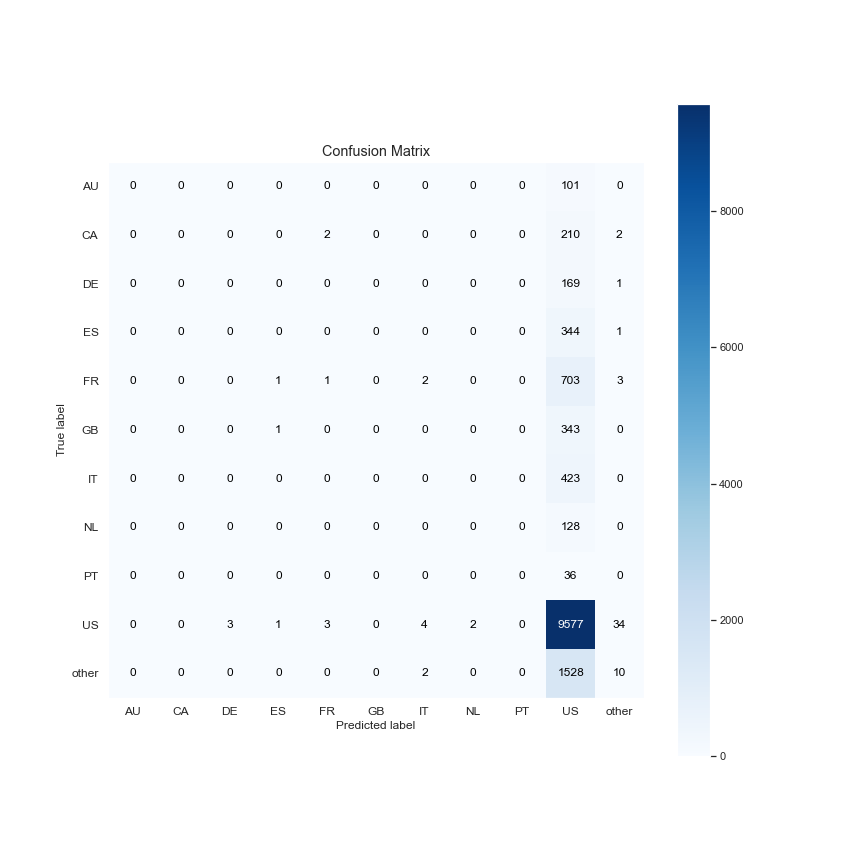

In [31]:
# Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy: {acc_nn}')

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa Score: {kappa_nn}')

# Classification Report 
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12));